<a href="https://colab.research.google.com/github/holly-hewitt/ML-Practical-Coursework/blob/main/Copy_of_adaptive_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Coursework 2 (Practical) for COMPSCI4061 / COMPSCI5014 Machine Learning H / M - 2023-24

### Problem Statement

The explicit task description for this assignment is at the bottom of this notebook.

In this assignment, we are going to explore an adaptive K-NN classifier. Usually, for K-NN classification (which is a non-parametric approach), we work with a fixed value of $k$. After storing the data instances and the labels, during the inference time for each point, we get its $k$-neighborhood and predict the majority label from its neighborhood as the label of the current point.

In this report, we are going to investigate if a variable $k$ (the value of which depends on the data instance) performs better than a static choice of $k$.

We are going to implement two different approaches - one based on heuristics, and the other based on a supervised parametric classifier that predicts the value of $k$ given a data instance.

The following block of code downloads and prepares the dataset to be used. It also shows some sample images from the training set.

11490434/11490434 [==============================] - 0s 0us/step


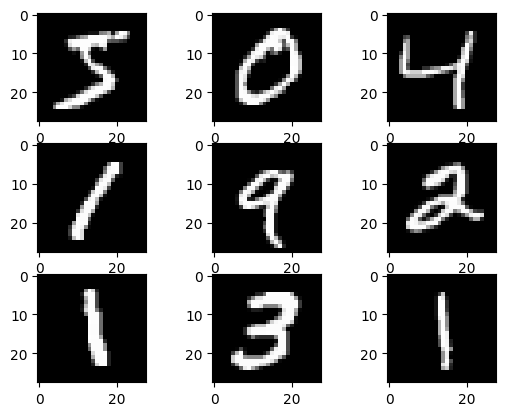

Train samples: (60000, 784) (60000, 1)
Test samples: (10000, 784) (10000, 1)
Evaluation set: (100, 784)
Train samples: (60000, 784) (60000,)
Test samples: (100, 784) (100,)


In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))

pyplot.show()


# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

NUM_TRAIN_SAMPLES = x_train.shape[0]
NUM_TEST_SAMPLES = x_test.shape[0]

print("Train samples: {} {}".format(x_train.shape, y_train.shape))
print("Test samples: {} {}".format(x_test.shape, y_test.shape))

# We conduct all the evaluation on a *small subset* of the test data
EVAL_SUBSET_SIZE = 100
eval_ids = np.random.randint(NUM_TEST_SAMPLES, size=EVAL_SUBSET_SIZE)
x_test = x_test[eval_ids,:]
y_test = y_test[eval_ids,:]

print("Evaluation set: {}".format(x_test.shape))

NUM_TRAIN_SAMPLES = x_train.shape[0]
NUM_TEST_SAMPLES = x_test.shape[0]
y_train = y_train.ravel()
y_test = y_test.ravel()

print("Train samples: {} {}".format(x_train.shape, y_train.shape))
print("Test samples: {} {}".format(x_test.shape, y_test.shape))

#### Learning with noisy labels

To demonstrate the necessity of the adaptive approach, we simulate noisy data by introducing the common mistakes.
For instance, we randomly change 3-->8, 8-->3, 1-->{4, 7}, 5-->6 etc.

The amount of noise injected as a part of this stochastic process is controlled by the paramater **noise_probability** ($\in [0, 1]$).


In [3]:
import random
noise_probability = 0.7

def corrupt_label(y, err):
    found = np.where(err == y)
    if len(found) > 0:
        # select an element at random (index != found)
        noisy_label = random.choice(err)
        while noisy_label == y:
            noisy_label = random.choice(err)
        return noisy_label
    return y

# We corrupt the MNIST data with some common mistakes, such as 3-->8, 8-->3, 1-->{4, 7}, 5-->6 etc.
def corrupt_labels(y_train, noise_probability):
    num_samples = y_train.shape[0]
    err_es_1 = np.array([0, 2, 3, 5, 6, 8, 9])
    err_es_2 = np.array([1, 4, 7])

    corruptions = {}
    corrupted_indexes = {}

    for i in range(num_samples):
        p = random.random()

        if p < noise_probability:
            y = y_train[i]
            y_noisy = corrupt_label(y, err_es_1)
            if y_noisy == y:
                y_noisy = corrupt_label(y, err_es_2)

            key = str(y_train[i]) + '->' + str(y_noisy)
            corrupted_indexes[i] = i

            if key in corruptions:
                corruptions[key] += 1
            else:
                corruptions[key] = 0

            y_train[i] = y_noisy

    return corruptions, corrupted_indexes

corruptions, corrupted_indexes = corrupt_labels(y_train, noise_probability)
print ("Corruptions: " + str(corruptions))
print ("Corrupted indexes: {}".format(list(corrupted_indexes.keys())[0:10]))


Corruptions: {'5->3': 646, '0->9': 659, '4->9': 565, '1->6': 646, '9->3': 720, '2->8': 689, '3->0': 698, '1->5': 676, '3->9': 732, '5->9': 635, '1->8': 677, '7->5': 595, '2->6': 671, '8->9': 720, '6->2': 715, '9->8': 658, '4->5': 580, '3->8': 739, '7->6': 642, '8->5': 694, '9->5': 690, '0->2': 658, '6->9': 691, '3->6': 723, '7->3': 638, '4->0': 592, '9->6': 693, '0->6': 729, '4->8': 584, '0->5': 715, '5->2': 640, '1->2': 676, '6->5': 663, '0->3': 682, '1->0': 722, '7->9': 612, '8->6': 619, '7->8': 569, '0->8': 707, '2->3': 672, '3->2': 667, '1->9': 658, '2->5': 673, '4->3': 575, '7->0': 654, '8->0': 727, '4->2': 590, '6->3': 671, '3->5': 758, '8->3': 683, '1->3': 683, '7->2': 639, '6->8': 694, '5->6': 619, '2->0': 757, '8->2': 715, '9->2': 704, '6->0': 737, '9->0': 684, '5->8': 639, '4->6': 597, '5->0': 637, '2->9': 689}
Corrupted indexes: [0, 1, 2, 3, 4, 5, 7, 8, 10, 11]


### Standard K-NN on this noisy data

We now execute static k-NN on this noisy data. The effectiveness of the classifier is very poor (for your own understanding, try to see why; note that answering this is not an actionable item and hence isn't graded).

In [4]:
K = 3

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=K)
model.fit(x_train, y_train)

print ("{}-NN model fitted".format(K))

y_preds = model.predict(x_test)
print ("K-NN model accuracy with k={}: {:.4f}".format(K, accuracy_score(y_test, y_preds)))

3-NN model fitted
K-NN model accuracy with k=3: 0.2200


We now would implement a simple unsupervised (heuristic-based) method to predict if we need a large or a small value of $k$ for a correct classification. Recall from the lecture notes that a dense neighborhood perhaps would be better served with a large value of $k$, whereas a relatively less compact neighborhood may do well with a small $k$. A sample function to estimate the quality of a neighborhood is the variance of the distances of the neighborhood points, i.e.,

$$\phi(N_k(\mathbf{x})) = \sum_{z \in N_k(\mathbf{x})} (d(\mathbf{x},\mathbf{z}) - \mu)^2, \text{where}\,\,\,\,\mu=\sum_{z \in N_k(\mathbf{x})} d(\mathbf{x},\mathbf{z}).$$

Notations:
 * $\mathbf{x}$: A data instance for inference.
 * $N_k(\mathbf{x})$: A neighborhood of size $k$ around the data instance for inference.
 * $d(\mathbf{x},\mathbf{z})$: Distance (Euclidean or cosine or any other) between the test point $\mathbf{x}$ and a training point $\mathbf{z}$.
 * $\mu$: The average of the distances of the neighboring training points from the test point.   


Again for your own understanding, try to see wheether it makes sense to argue that the higher the variance, the less compact is the neighborhood, and perhaps we want a smaller $k$ for such ones? (no actionable item and no grading for finding this answer)

Our task is now to write the function *predict_k_values_unsupervised*.

In [5]:
import math

# Takes the test set and an index of nearest neighbors.
# Iterates over each point, computes the variance of distances, scales that into the range [1, MAX_K]
# and returns a list of adaptively chosen K values (one for each instance).
def predict_k_values_unsupervised(x_test, nn_index):
    n = x_test.shape[0]
    variances = []
    for i in range(n):
        x = x_test[i]
        distances, ids = nn_index.kneighbors([x], return_distance=True)
        variances.append(np.var(distances))

    min_v = min(variances)
    max_v = max(variances)

    k_values = [1 + math.floor((MAX_K-1) * (float(var) - min_v)/(max_v - min_v)) for var in variances]
    return k_values

In [30]:
# For adaptively choosing $k$ we need to set an upper bound (the lower bound being 1).
MAX_K = 20

from sklearn.neighbors import NearestNeighbors

def adaptive_knn(x_test, y_test):

    # Build the index so that we retrieve the neighborhoods faster
    nn_index = NearestNeighbors(n_neighbors=MAX_K).fit(x_train)

    #print ("{}-NN index built".format(MAX_K))

    # Dynamic k workflow
    k_values = predict_k_values_unsupervised(x_test, nn_index)
    y_preds = []

    for i in range(len(x_test)):
        k = k_values[i]

        #print ("Predicting with nn-size = {}".format(k))
        x = x_test[i]
        distances, ids = nn_index.kneighbors([x])
        ids = ids.flatten()

        ids = ids[:k] # take the first k (out of MAX_K)
        nn_labels = []
        for x_id in ids:
            nn_labels.append(y_train[x_id])

        y_pred = max(set(nn_labels), key=nn_labels.count)
        y_preds.append(y_pred)

    accuracy = accuracy_score(y_test, y_preds)
    return accuracy

In [7]:
accuracy = adaptive_knn(x_test, y_test)
print ("Adaptive K-NN model accuracy: {:.4f}".format(accuracy))

20-NN index built
Adaptive K-NN model accuracy: 0.2800


#### Tasks: Investigate if we can do better than the heuristics.

We now seek to learn a function of the form $\theta: \mathbf{x} \mapsto \mathbb{Z}_k$ (e.g., via $k$-class softmax regression or an SVM or any other parametric classifier).

**Task 1 (30 marks)**: Replace the function *predict_k_values_unsupervised* with another function *predict_k_values_supervised* which will do the following:
- Learn a mapping between a data instance from the training set and the smallest value of $k$ that results in correct predictions for that instance. In your report, clearly describe how do you train this classifier (e.g., what are the ground-truth y values for each training data point $\mathbf{x} \in S_{train}$.    
- Apply this paramateric model to *predict* the value of $k$ at inference time (for this you just need to replace the call to **predict_k_values_unsupervised** inside **adaptive_knn** with your implemented method).

**Task 2 (30 marks)**: Compare the performance of your implemented supervised approach vs. the baseline (unsupervised one) for different simulated datasets with varying amounts of noise. Make a plot with *noise_probability* on the x-axis and accuracy on the y-axis for 11 different values - {0, 0.1, ... 0.9, 1}.

**Task 3 (40 marks)**: Write a commentary on the observations reflecting on your approach (e.g., on the assumptions you make, on the hyper-parameter choices for your method etc.) and figuring out **when and why it works** (e.g., for what hyper-parameter settings), and **when and why it doesn't**.
  - 3(a): Clear description of the assumptions, the experiment settings (e.g., different levels of noises) and hyper-parameters of your approach (e.g., learning rate or regularisation constant of softmax regression) (10 marks).
  - 3(b): Sensitivity analysis of the hyper-parameters (ideally should be demonsrated with plots of results) (15 marks).
  - 3(c): Your observations and conclusions on per-instance error analysis, e.g., what happens in different types (different levels of compactness or homogeneity) of neighborhoods (15 marks).


# Task 1

In [8]:
# Function to generate ground truth k values
def gen_k_ground_truth(x_test, y_test, x_train, y_train, subsample_fraction = 0.1):
    # Use a subsample of the training data to build the k-NN index
    subsample_size = int(len(x_train) * subsample_fraction)
    subsample_indices = np.random.choice(len(x_train), subsample_size, replace=False)
    x_train_subsample = x_train[subsample_indices]
    y_train_subsample = y_train[subsample_indices]
    nn_index = NearestNeighbors(n_neighbors=len(x_train_subsample)).fit(x_train_subsample)

    print("{}-NN index built with a subsample of {} training instances".format(len(x_train_subsample), subsample_size))

    # Use a subsample of the test dataset to generate ground truth values for k
    subsample_size = int(len(x_test) * subsample_fraction)
    subsample_indices = np.random.choice(len(x_test), subsample_size, replace=False)
    x_test_subsample = x_test[subsample_indices]
    y_test_subsample = y_test[subsample_indices]

    k_values = []
    print(len(x_test_subsample))

    for i in range(len(x_test_subsample)):


        x = x_test_subsample[i]
        y = y_test_subsample[i]

        distances, ids = nn_index.kneighbors([x])
        ids = ids.flatten()

        ids = ids[:len(x_train_subsample)]  # take the first k (out of the subsample)
        nn_labels = [y_train_subsample[x_id] for x_id in ids]

        k = 1
        while k < MAX_K:
            y_pred = max(set(nn_labels[:k]), key=nn_labels[:k].count)
            if y_pred == y:
                break
            k += 1
        #if (i % 100) == 0:
            #print("x value", i)
            #print(k)
        k_values.append(k)

    return k_values, x_test_subsample


In [9]:
from sklearn.model_selection import train_test_split

# create subsamples of x_train and y_train for creating ground truth values of k

x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)
k_vals, x_test_subsample = gen_k_ground_truth(x_test_sub, y_test_sub, x_train_sub, y_train_sub)
x_train_k, x_test_k, k_train_k, k_test_k = train_test_split(x_test_subsample, k_vals, test_size=0.2, random_state=42)

4800-NN index built with a subsample of 4800 training instances
1200


In [29]:
from sklearn.linear_model import LogisticRegression

def fit_classifier():
  print("Generating training subsamples...")
  x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)
  print("Generating ground truth k values...")
  k_vals, x_test_subsample = gen_k_ground_truth(x_test_sub, y_test_sub, x_train_sub, y_train_sub)
  x_train_k, x_test_k, k_train_k, k_test_k = train_test_split(x_test_subsample, k_vals, test_size=0.2, random_state=42)

  # Train a logistic regression classifier
  classifier = LogisticRegression(max_iter=1000, random_state=42)
  print("Fitting a classifier to x values and k values...")
  classifier.fit(x_train_k, k_train_k)
  return classifier

def predict_k_values_supervised(x_test):
  print("Generating training subsamples...")
  x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)
  print("Generating ground truth k values...")
  k_vals, x_test_subsample = gen_k_ground_truth(x_test_sub, y_test_sub, x_train_sub, y_train_sub)
  x_train_k, x_test_k, k_train_k, k_test_k = train_test_split(x_test_subsample, k_vals, test_size=0.2, random_state=42)

  # Train a logistic regression classifier
  classifier = LogisticRegression(max_iter=1000, random_state=42)
  print("Fitting a classifier to x values and k values...")
  classifier.fit(x_train_k, k_train_k)

  # Predict k values for the test set
  print("Predicting k values for test dataset...")
  k_pred = classifier.predict(x_test)

  # Print or use the predicted k values as needed
  return(k_pred)

In [28]:
# For adaptively choosing $k$ we need to set an upper bound (the lower bound being 1).
MAX_K = 20

from sklearn.neighbors import NearestNeighbors

def adaptive_knn_v1(x_test, y_test):

    # Build the index so that we retrieve the neighborhoods faster
    nn_index = NearestNeighbors(n_neighbors=MAX_K).fit(x_train)

    #print ("{}-NN index built".format(MAX_K))

    # Dynamic k workflow
    k_values = predict_k_values_supervised(x_test)
    y_preds = []

    for i in range(len(x_test)):
        k = k_values[i]

        #print ("Predicting with nn-size = {}".format(k))
        x = x_test[i]
        distances, ids = nn_index.kneighbors([x])
        ids = ids.flatten()

        ids = ids[:k] # take the first k (out of MAX_K)
        nn_labels = []
        for x_id in ids:
            nn_labels.append(y_train[x_id])

        y_pred = max(set(nn_labels), key=nn_labels.count)
        y_preds.append(y_pred)

    accuracy = accuracy_score(y_test, y_preds)
    return accuracy

In [15]:
classifier = fit_classifier()
accuracy = adaptive_knn_v1(x_test, y_test)
print ("Adaptive K-NN model accuracy: {:.4f}".format(accuracy))

Generating training subsamples...
Generating ground truth k values...
4800-NN index built with a subsample of 4800 training instances
1200
Fitting a classifier to x values and k values...
20-NN index built
Predicting k values for test dataset...
Adaptive K-NN model accuracy: 0.5300


The model works!!!! With higher levels of accuracy!!!

# Task 2: Attempt 1

In [70]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def corrupt_label(y, err):
    found = np.where(err == y)
    if len(found) > 0:
        # select an element at random (index != found)
        noisy_label = random.choice(err)
        while noisy_label == y:
            noisy_label = random.choice(err)
        return noisy_label
    return y

def corrupt_labels(y_train, noise_probability):
    num_samples = y_train.shape[0]
    err_es_1 = np.array([0, 2, 3, 5, 6, 8, 9])
    err_es_2 = np.array([1, 4, 7])

    corruptions = {}
    corrupted_indexes = {}

    for i in range(num_samples):
        p = random.random()

        if p < noise_probability:
            y = y_train[i]
            y_noisy = corrupt_label(y, err_es_1)
            if y_noisy == y:
                y_noisy = corrupt_label(y, err_es_2)

            key = str(y_train[i]) + '->' + str(y_noisy)
            corrupted_indexes[i] = i

            if key in corruptions:
                corruptions[key] += 1
            else:
                corruptions[key] = 0

            y_train[i] = y_noisy

    return corruptions, corrupted_indexes

# Run the function to generate the plot
#plot_accuracy_vs_noise_probability()

def generate_simulated_dataset_with_noise(x_data, y_data, noise_probability):
    x_corrupted = x_data.copy()
    y_corrupted = y_data.copy()

    _, corrupted_indexes = corrupt_labels(y_corrupted, noise_probability)

    return x_corrupted, y_corrupted, list(corrupted_indexes.keys())

def plot_accuracy_vs_noise_probability():
    noise_probabilities = np.linspace(0, 1, 11)
    accuracies = []

    for noise_probability in noise_probabilities:
        x_train_corrupted, y_train_corrupted, _ = generate_simulated_dataset_with_noise(x_train, y_train, noise_probability)
        x_train_split, x_val_split, y_train_split, y_val _split = train_test_split(x_train_corrupted, y_train_corrupted, test_size=0.2, random_state=42)
        accuracy = adaptive_knn_v1(x_val_split, y_val_split)
        accuracies.append(accuracy)

    plt.plot(noise_probabilities, accuracies, marker='o')
    plt.xlabel('Noise Probability')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Noise Probability')
    plt.show()

# Run the function to generate the plot
plot_accuracy_vs_noise_probability()


20-NN index built
Generating training subsamples...
Generating ground truth k values...
4800-NN index built with a subsample of 4800 training instances
1200
Fitting a classifier to x values and k values...
Predicting k values for test dataset...


KeyboardInterrupt: ignored

# Task 2: Attempt 2

In [33]:
probs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
supervised_acc = []
unsupervised_acc = []
for p in probs:
  print("Iteration with p :", p)
  corruptions, corrupted_indexes = corrupt_labels(y_train, p)
  print("Performing unsupervised approach...")
  #unsupervised approach
  accuracy1 = adaptive_knn(x_test, y_test)
  unsupervised_acc.append(accuracy1)

  print("Performing supervised approach...")
  #supervised approach
  accuracy2 = adaptive_knn_v1(x_test, y_test)
  supervised_acc.append(accuracy2)
  print("\n")

Iteration with p : 0
Performing unsupervised approach...
Performing supervised approach...
Generating training subsamples...
Generating ground truth k values...
4800-NN index built with a subsample of 4800 training instances
1200
Fitting a classifier to x values and k values...
Predicting k values for test dataset...


Iteration with p : 0.1
Performing unsupervised approach...
Performing supervised approach...
Generating training subsamples...
Generating ground truth k values...
4800-NN index built with a subsample of 4800 training instances
1200
Fitting a classifier to x values and k values...
Predicting k values for test dataset...


Iteration with p : 0.2
Performing unsupervised approach...
Performing supervised approach...
Generating training subsamples...
Generating ground truth k values...
4800-NN index built with a subsample of 4800 training instances
1200
Fitting a classifier to x values and k values...
Predicting k values for test dataset...


Iteration with p : 0.3
Performing

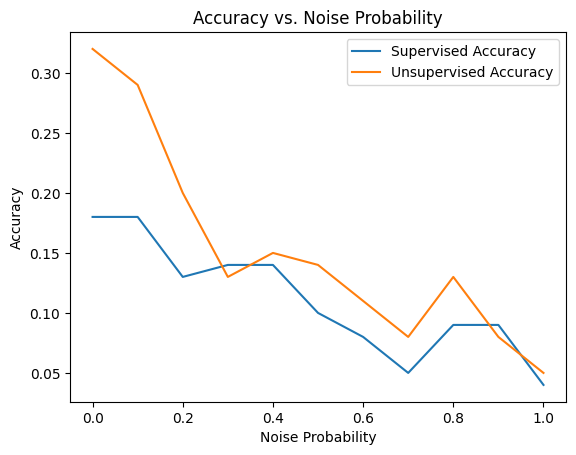

In [25]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(probs, supervised_acc, label='Supervised Accuracy')
plt.plot(probs, unsupervised_acc, label='Unsupervised Accuracy')
plt.xlabel('Noise Probability')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Noise Probability')
plt.legend()
plt.show()

# Task 3


Hyperparameter analysis
- Different values of k
- Different values of subsampling
-

In [ ]:
# Define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Specify the range of values for C
    'penalty': ['l1', 'l2'],  # L1 (Lasso) or L2 (Ridge) penalty
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Different optimization algorithms
    'class_weight': [None, 'balanced'],  # Class weight options
    'tol': [1e-4, 1e-3, 1e-2]  # Tolerance for stopping criteria
}

# Create a logistic regression classifier
classifier = LogisticRegression(max_iter=1000, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the results as a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class LogisticRegressionWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, penalty='l2', solver='lbfgs'):
        self.C = C
        self.penalty = penalty
        self.solver = solver
        self.classifier = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=1000, random_state=42)

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classifier.fit(X, y)
        return self

    def predict(self, X):
        check_is_fitted(self, 'classifier')
        X = check_array(X)
        return self.classifier.predict(X)

def adaptive_knn_v1(x_test, y_test, param_grid_logreg):
    # Build the index so that we retrieve the neighborhoods faster
    nn_index = NearestNeighbors(n_neighbors=MAX_K).fit(x_train)

    print("{}-NN index built".format(MAX_K))

    # Dynamic k workflow
    k_values = predict_k_values_supervised(x_test, param_grid_logreg)
    y_preds = []

    for i in range(len(x_test)):
        k = k_values[i]

        # print ("Predicting with nn-size = {}".format(k))
        x = x_test[i]
        distances, ids = nn_index.kneighbors([x])
        ids = ids.flatten()

        ids = ids[:k]  # take the first k (out of MAX_K)
        nn_labels = []
        for x_id in ids:
            nn_labels.append(y_train[x_id])

        y_pred = max(set(nn_labels), key=nn_labels.count)
        y_preds.append(y_pred)

    accuracy = accuracy_score(y_test, y_preds)
    return accuracy

def predict_k_values_supervised(x_test, param_grid_logreg):
    print("Generating training subsamples...")
    x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(x_train, y_train, test_size=0.2,
                                                                        random_state=42)
    print("Generating ground truth k values...")
    k_vals, x_test_subsample = gen_k_ground_truth(x_test_sub, y_test_sub, x_train_sub, y_train_sub)
    x_train_k, x_test_k, k_train_k, k_test_k = train_test_split(x_test_subsample, k_vals, test_size=0.2,
                                                                random_state=42)

    # Create a logistic regression classifier
    logreg_classifier = LogisticRegressionWrapper()

    # Create GridSearchCV object for hyperparameter tuning
    grid_search = GridSearchCV(logreg_classifier, param_grid_logreg, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit the grid search to the data
    grid_search.fit(x_train_k, k_train_k)

    # Get the best hyperparameters for logistic regression
    best_params_logreg = grid_search.best_params_

    # Use the best logistic regression hyperparameters
    best_logreg = LogisticRegressionWrapper(**best_params_logreg)

    # Train the logistic regression classifier with the best hyperparameters
    best_logreg.fit(x_train_k, k_train_k)

    # Predict k values for the test set
    print("Predicting k values for test dataset...")
    k_pred = best_logreg.predict(x_test)

    # Print or use the predicted k values as needed
    return k_pred

# Define the parameter grid for logistic regression
param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Specify the range of values for C
    'penalty': ['l1', 'l2'],  # L1 (Lasso) or L2 (Ridge) penalty
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Different optimization algorithms
}

# Call adaptive_knn_v1 with the logistic regression hyperparameter grid
accuracy2 = adaptive_knn_v1(x_test, y_test, param_grid_logreg)

print("Accuracy of the wider classifier:", accuracy2)


20-NN index built
Generating training subsamples...
Generating ground truth k values...
4800-NN index built with a subsample of 4800 training instances
1200
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Predicting k values for test dataset...
Accuracy of the wider classifier: 0.08


In [35]:
def adaptive_knn_v2(inner_clf, x_test, y_test):

    # Build the index so that we retrieve the neighborhoods faster
    nn_index = NearestNeighbors(n_neighbors=MAX_K).fit(x_train)

    #print ("{}-NN index built".format(MAX_K))

    # Dynamic k workflow
    print("Generating training subsamples...")
    x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)
    print("Generating ground truth k values...")
    k_vals, x_test_subsample = gen_k_ground_truth(x_test_sub, y_test_sub, x_train_sub, y_train_sub)
    x_train_k, x_test_k, k_train_k, k_test_k = train_test_split(x_test_subsample, k_vals, test_size=0.2, random_state=42)

    # Train a logistic regression classifier
    #classifier = LogisticRegression(max_iter=1000, random_state=42)
    print("Fitting a classifier to x values and k values...")
    inner_clf.fit(x_train_k, k_train_k)

    # Predict k values for the test set
    print("Predicting k values for test dataset...")
    k_values = inner_clf.predict(x_test)


    y_preds = []

    for i in range(len(x_test)):
        k = k_values[i]

        #print ("Predicting with nn-size = {}".format(k))
        x = x_test[i]
        distances, ids = nn_index.kneighbors([x])
        ids = ids.flatten()

        ids = ids[:k] # take the first k (out of MAX_K)
        nn_labels = []
        for x_id in ids:
            nn_labels.append(y_train[x_id])

        y_pred = max(set(nn_labels), key=nn_labels.count)
        y_preds.append(y_pred)

    accuracy = accuracy_score(y_test, y_preds)
    return accuracy



In [ ]:
inner_clf = LogisticRegression(max_iter=1000, random_state=42)

# Define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Specify the range of values for C
    'penalty': ['l1', 'l2'],  # L1 (Lasso) or L2 (Ridge) penalty
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Different optimization algorithms
    'class_weight': [None, 'balanced'],  # Class weight options
    'tol': [1e-4, 1e-3, 1e-2]  # Tolerance for stopping criteria
}

# Create GridSearchCV object for hyperparameter tuning
grid_search = GridSearchCV(inner_clf, param_grid, cv=5, scoring=adaptive_knn_v2, verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)
all_results = grid_search.cv_results


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
